Tutorial: https://www.youtube.com/watch?v=DbESHcCoWbM&list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2&index=3

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! pip install pytorch-lightning

     |████████████████████████████████| 675kB 15.7MB/s 
     |████████████████████████████████| 829kB 57.6MB/s 
     |████████████████████████████████| 92kB 14.4MB/s 
     |████████████████████████████████| 276kB 57.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=3040015e1b608285ccf56f8716b0324bf81e9fa05cc727efdbb4a22cf6e909ab
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=f8d370cce58c0d270251b72eaf10923608de5c043344b9e8aa2ffe97655c9144
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully un

In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from argparse import ArgumentParser

---
#PyTorch Lightning

1. model
2. optimizer
3. data
4. training loop "the magic"
5. validation loop "the validation magic"

In [10]:
# Data Module
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        # download only
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
        datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

    def setup(self, stage):
        # transform
        transform=transforms.Compose([transforms.ToTensor()])
        training_dataset = datasets.MNIST('data', train=True, download=False, transform=transform)
        test_dataset = datasets.MNIST('data', train=False, download=False, transform=transform)

        # train/val split
        mnist_train, mnist_val = random_split(training_dataset, [55000, 5000])

        # assign to use in dataloaders
        self.train_dataset = mnist_train
        self.val_dataset = mnist_val
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [9]:
train_accuracy = pl.metrics.Accuracy()
valid_accuracy = pl.metrics.Accuracy(compute_on_step=False)

class ResNet(pl.LightningModule):
  def __init__(self,lr=1e-3):
    super().__init__()
    self.l1 = nn.Linear(28 * 28, 64)
    self.l2 = nn.Linear(64,64)
    self.l3 = nn.Linear(64,10)
    self.do = nn.Dropout(0.1)

    self.learning_rate = lr

    self.loss = nn.CrossEntropyLoss()    
  
  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    do = self.do(h2+h1)
    logits = self.l3(do)
    return logits

  # def backward(self, trainer, loss, optimizer, optimizer_idx):
  #   loss.backward()
  
  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def training_step(self,batch,batch_idx):
    x,y = batch
    
    # x: bx 1 x 28 x 28
    b = x.size(0)
    x = x.view(b,-1)
    
    # Step 1 : Forward
    logits = self(x)
    
    # Step 2 : Compute the objective function
    J = self.loss(logits,y)

    acc = accuracy(logits,y)
    pbar = {'train_acc': acc}
    return {'loss':J, 'progress_bar':pbar}
    # return J
  
  def validation_step(self,batch,batch_idx):
    results = self.training_step(batch,batch_idx)
    results['progress_bar']['val_acc'] = results['progress_bar']['train_acc']
    del results['progress_bar']['train_acc']
    return results

  def validation_epoch_end(self,val_step_outputs):
    avg_val_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()
    avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_step_outputs]).mean()

    pbar = {'avg_val_acc': avg_val_acc}
    return {'val_loss': avg_val_loss, 'progress_bar': pbar}

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | l1   | Linear           | 50.2 K
1 | l2   | Linear           | 4.2 K 
2 | l3   | Linear           | 650   
3 | do   | Dropout          | 0     
4 | loss | CrossEntropyLoss | 0     
------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the ligh

0.01


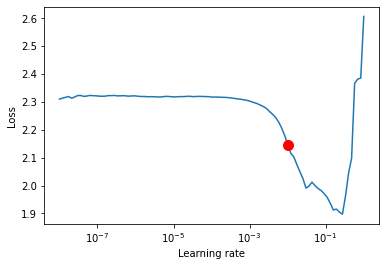

In [17]:
model = ResNet()
mnist_dm = MNISTDataModule()
trainer = pl.Trainer(progress_bar_refresh_rate=20,
                     max_epochs=5,
                     gpus=(1 if torch.cuda.is_available() else 0),
                     auto_lr_find=True)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,mnist_dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(new_lr)

In [18]:
# update hparams of the model
model.hparams.lr = new_lr

In [19]:
# Fit Model
trainer.fit(model,mnist_dm)


  | Name | Type             | Params
------------------------------------------
0 | l1   | Linear           | 50.2 K
1 | l2   | Linear           | 4.2 K 
2 | l3   | Linear           | 650   
3 | do   | Dropout          | 0     
4 | loss | CrossEntropyLoss | 0     
------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [5]:
ls lightning_logs/

version_0/  version_1/  version_2/  version_3/
